Ideas:
* Find method for determining the number of EOFs that are statistically significant, how many EOFs needed to reconstruct -- something to calculate this threshold, Chris Bretherton, Dennis??

# Set up workspace

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from eofs.xarray import Eof 

In [3]:
import cftime
import scipy

In [4]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

import make_multisimulation_dataset
from load_ensembles import *

In [5]:
from load_ensembles import *
import quick_map

In [6]:
import make_multisimulation_dataset

# Load data

In [7]:
var='TSKIN'
domain='lnd'
ensemble='coupled'

In [8]:
end_spinup=60

## Load full ensemble data

In [8]:
if ensemble=='coupled':
    ensemble_coupled = load_coupled_ensemble(var=var, domain=domain, printon=False)
elif ensemble=='offline':
    ensemble_coupled = load_offline_ensemble(var=var, domain=domain, printon=False)

/glade/u/home/czarakas/coupled_PPE/code/utils/load_ensembles.py:46: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fpath)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [9]:
if ensemble=='offline':
    if domain=='atm':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/atm/proc/tseries/OFFL0000_PI_v02.cam.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    elif domain=='lnd':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/lnd/proc/tseries/OFFL0000_PI_v02.clm2.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
elif ensemble=='coupled':
    if domain=='atm':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                                 'COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    elif domain=='lnd':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                                 'COUP0000_PI_SOM/lnd/proc/tseries/COUP0000_PI_SOM.clm2.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
from load_gridcell_areas import *

### Function for calculating annual averages based on days per year

In [11]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
    return month_length

In [12]:
ds=basecase_lnd
month_length = xr.DataArray(get_dpm(ds.time.to_index(),
                                      calendar='noleap'),
                              coords=[ds.time], name='month_length')

numyears=np.size(ds.time.groupby('time.year').mean(dim='time').year)

In [13]:
# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()

# Test that the sum of the weights for each season is 1.0
#weights.groupby('time.month').sum().values
np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))

# Calculate the weighted average
ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')

In [14]:
def calculate_annual_timeseries(ds, var=var, season='Annual'):
    month_length = xr.DataArray(get_dpm(ds.time.to_index(),
                                      calendar='noleap'),
                              coords=[ds.time], name='month_length')
    
    numyears=np.size(ds.time.groupby('time.year').mean(dim='time'))
    
    if season=='Annual':
        weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()
        
        # Test that the sum of the weights for each year is 1.0
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))
    
        # Calculate the weighted average
        ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')
        
        this_ensemble_tseries=ds_weighted[end_spinup:,:,:]
    else:
        months_filtered = month_length.where(month_length['time.season']==season)
        weights = months_filtered.groupby('time.year') / months_filtered.astype(float).groupby('time.year').sum()
        
        # Test that the sum of the weights for each season is 1.0
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))
        
        ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')
        this_ensemble_tseries=ds_weighted[end_spinup:,:,:]
        
    return this_ensemble_tseries
    

# Check ensemble

In [15]:
ensemble_coupled[-1]=ensemble_coupled[-1].sel(time=slice('0049-01-16', '0188-12-16'))

In [16]:
expected_start_time=cftime.DatetimeNoLeap(49,1,16,12)
expected_end_time=cftime.DatetimeNoLeap(188,12,16,12)
for i,ds in enumerate(ensemble_coupled):
    print(ds.case_id)
    if np.size(ds.time)!=1680:
        print('!!!!! Time size is wrong dimension')
    if ds.time.values[0] != expected_start_time:
        print(ds.time.values[0])
    if ds.time.values[-1] != expected_end_time:
        print(ds.time.values[-1])
    print('----------')

COUP0001_PI_SOM_v02
----------
COUP0037_PI_SOM_v02
----------
COUP0007_PI_SOM_v02
----------
COUP0008_PI_SOM_v02
----------
COUP0009_PI_SOM_v02
----------
COUP0010_PI_SOM_v02
----------
COUP0013_PI_SOM_v02
----------
COUP0014_PI_SOM_v02
----------
COUP0015_PI_SOM_v02
----------
COUP0016_PI_SOM_v02
----------
COUP0017_PI_SOM_v02
----------
COUP0018_PI_SOM_v02
----------
COUP0019_PI_SOM_v02
----------
COUP0020_PI_SOM_v02
----------
COUP0021_PI_SOM_v02
----------
COUP0022_PI_SOM_v02
----------
COUP0023_PI_SOM_v02
----------
COUP0024_PI_SOM_v02
----------
COUP0025_PI_SOM_v02
----------
COUP0026_PI_SOM_v02
----------
COUP0027_PI_SOM_v02
----------
COUP0028_PI_SOM_v02
----------
COUP0029_PI_SOM_v02
----------
COUP0030_PI_SOM_v02
----------
COUP0031_PI_SOM_v02
----------
COUP0032_PI_SOM_v02
----------
COUP0033_PI_SOM_v02
----------
COUP0034_PI_SOM_v02
----------
COUP0035_PI_SOM_v02
----------
COUP0036_PI_SOM_v02
----------
COUP0003_PI_SOM_v02
----------
COUP0004_PI_SOM_v02
----------
COUP0005

# Calculate annual means

In [17]:
num_ensemble=np.shape(ensemble_coupled)[0]
num_seasons=4

# Calculate seasonal cycle of reference simulation
seasonal_cycle_ref=[]
for j,season in enumerate(['DJF','MAM','JJA','SON']):
    ref_tseries=calculate_annual_timeseries(basecase_lnd,season=season).mean(dim='year')
    seasonal_cycle_ref.append((ref_tseries*landweights).mean(dim=['lat','lon']))

# Calculate seasonal cycle of ensemble members
seasonal_cycle=np.zeros([num_ensemble, num_seasons])
seasonal_cycle[:]=np.nan
for i,ds in enumerate(ensemble_coupled):
    print(i)
    for j,season in enumerate(['DJF','MAM','JJA','SON']):
        seasonal_avg=(calculate_annual_timeseries(ds, var=var, season=season).mean(dim='year')*
                      landweights).mean(dim=['lat','lon'])
        seasonal_cycle[i,j]=seasonal_avg.load()

seasonal_cycle_diff=seasonal_cycle-np.array(seasonal_cycle_ref)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [18]:
seasonal_cycle_diff=seasonal_cycle-np.array(seasonal_cycle_ref)

In [19]:
# Calculate seasonal cycle of reference simulation
season='Annual'
ref_annual=calculate_annual_timeseries(basecase_lnd,season=season).mean(dim='year')
ref_annual_global=((ref_annual*landweights).mean(dim=['lat','lon']))

# Calculate seasonal cycle of ensemble members
annual_avgs=[]
for i,ds in enumerate(ensemble_coupled):
    print(i)
    annual_avg=(calculate_annual_timeseries(ds, var=var, season=season).mean(dim='year')*
                      landweights).mean(dim=['lat','lon'])
    annual_avgs.append(annual_avg.load())
    
annual_diffs=np.array(annual_avgs)-ref_annual_global.values

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


skipped
0.04051118206382398
-----
skipped
-0.0452949844310524
-----
skipped
-0.044039961321288956
-----
skipped
0.04653545738710818
-----
skipped
0.0665431164477468
-----
skipped
-0.09036474704862485
-----
skipped
-0.052852412634194934
-----
skipped
-0.0038234694228549415
-----
skipped
0.005989035899744977
-----
skipped
0.006944550648825043
-----
skipped
0.0006884382825091961
-----
skipped
0.06162584343525168
-----
skipped
-0.015215916568593002
-----
skipped
-0.05542196662548804
-----
skipped
0.14747844660871579
-----
skipped
-0.03342182697315366
-----
skipped
0.12885138203375845
-----
skipped
-0.020970406446792822
-----
skipped
0.02339846776152399
-----
skipped
-0.02489084107327244
-----
skipped
0.05754923014859514
-----
skipped
-0.019823640408844767
-----
skipped
0.0581666562375176
-----
skipped
0.11408526189057966
-----
skipped
-0.044512400527025875
-----
skipped
0.01829520382904093
-----
skipped
-0.014033826553145445
-----
skipped
0.06008466534922263
-----
skipped
-0.03468308855138

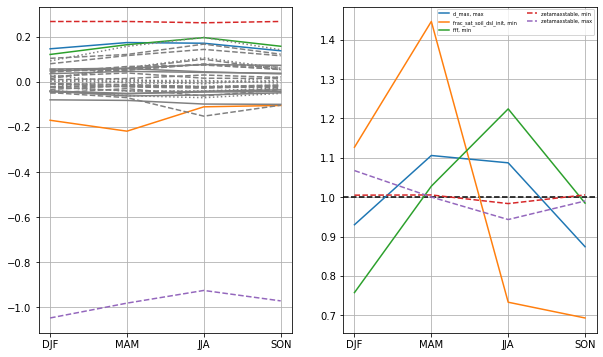

In [20]:
threshold_seasonal_cycle=0.15
x=[0,1,2,3]
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
for i,ds in enumerate(ensemble_coupled):
    if i>18:
        linestyle='--'
    elif i>9:
        linestyle=':'
    else:
        linestyle='-'
    if np.abs(annual_diffs[i])>threshold_seasonal_cycle:
        plt.plot(x,seasonal_cycle_diff[i,:],linestyle)
    else:
        plt.plot(x,seasonal_cycle_diff[i,:],linestyle,color='gray')
my_xticks = ['DJF','MAM','JJA','SON']
plt.xticks(x, my_xticks)
plt.grid()

plt.subplot(1,2,2)
plt.axhline(y=1,linestyle='--',color='k')
for i,ds in enumerate(ensemble_coupled):
    if i>18:
        linestyle='--'
    elif i>9:
        linestyle=':'
    else:
        linestyle='-'
    if np.abs(annual_diffs[i])>threshold_seasonal_cycle:
        plt.plot(x,seasonal_cycle_diff[i,:]/annual_diffs[i],linestyle,
                 label=crosswalk.description.values[i])#label=np.round(annual_diffs[i],2))
    else:
        print('skipped')
        print(annual_diffs[i])
        print('-----')
        #plt.plot(x,seasonal_cycle_diff[i,:]/annual_diffs[i],linestyle,color='gray',
        #         label=crosswalk.description.values[i])
        
my_xticks = ['DJF','MAM','JJA','SON']
plt.legend(ncol=2,fontsize=5)
plt.xticks(x, my_xticks)
plt.grid()

In [21]:
max_season=[]
for i,ds in enumerate(ensemble_coupled):
    max_season.append(np.argmax(np.abs(seasonal_cycle_diff[i,:])))

In [22]:
unique, counts = np.unique(np.array(max_season), return_counts=True)

In [23]:
counts*100/np.sum(counts)

array([13.88888889, 16.66666667, 55.55555556, 13.88888889])

In [117]:
DJF:
    'd_max, min', 'frac_sat_soil_dsl_init, max', 'z0mr, min',
       'z0mr, max', 'zsno, min'
MAM:
    'rhosnir, max', 'frac_sat_soil_dsl_init, min',
       'upplim_destruct_metamorph, max', 'nstem, min', 'lmrha, max',
       'zetamaxstable, min'
JJA:'d_max, max', 'maximum_leaf_wetted_fraction, max', 'fff, min',
       'fff, max', 'medlynslope, max', 'tpu25ratio, min', 'jmaxb0, max',
       'jmaxb1, min', 'jmaxb1, max', 'kmax, min', 'kmax, max',
       'nstem, max', 'lmrha, min', 'medlynslope, min', 'jmaxb0, min',
       'medlynintercept, max', 'sand_pf, min', 'sand_pf, max',
       'zsno, max', 'zetamaxstable, max'
    
SON:'rhosnir, min', 'maximum_leaf_wetted_fraction, min',
       'upplim_destruct_metamorph, min', 'medlynintercept, min',
       'tpu25ratio, max'

array([False,  True, False, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False])

In [24]:
crosswalk.description.values[np.array(max_season)==3]

array(['rhosnir, min', 'maximum_leaf_wetted_fraction, min',
       'upplim_destruct_metamorph, min', 'medlynintercept, min',
       'tpu25ratio, max'], dtype=object)

# T Test significance of changes

In [15]:
season='Annual'#'Annual','DJF,'MAM','JJA','SON'

In [22]:
ds_grid = ensemble_coupled[0]

var_array_ttest = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)
var_array_pval = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Calculate where changes are significant

In [23]:
ref_tseries=calculate_annual_timeseries(basecase_lnd,season=season)
for i, ds in enumerate(ensemble_coupled):
    ds_annual=calculate_annual_timeseries(ds, var=var, season=season)
    [tstat, pval] = scipy.stats.ttest_ind(ref_tseries, ds_annual, equal_var=False)#, alternative='two-sided')
    diff=ds_annual.mean(dim='year')-ref_tseries.mean(dim='year')
    var_array_ttest[:,:,i]=tstat
    var_array_pval[:,:,i]=pval

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/E

### Print fraction of land surface where changes are significant

In [28]:
fracs_changed = []
for i, ds in enumerate(ensemble_coupled):
    print(ds.case_id)
    print(crosswalk.description.values[(crosswalk.key_landonlyPPE==ds.case_id[0:8]).values][0])
    pval=var_array_pval[:,:,i]
    sig_mask=(pval<=0.05)
    frac_changed=(sig_mask*landweights).mean(dim=['lat','lon'])
    fracs_changed.append(frac_changed.values)
    print(frac_changed.values)
    print('-----------')

OFFL0001_PI_v02
rhosnir, min
0.025431724
-----------
OFFL0002_PI_v02
rhosnir, max
0.033717994
-----------
OFFL0007_PI_v02
d_max, min
0.078454465
-----------
OFFL0008_PI_v02
d_max, max
0.2900429
-----------
OFFL0009_PI_v02
frac_sat_soil_dsl_init, min
0.2744413
-----------
OFFL0010_PI_v02
frac_sat_soil_dsl_init, max
0.08313848
-----------
OFFL0013_PI_v02
maximum_leaf_wetted_fraction, min
0.16156496
-----------
OFFL0014_PI_v02
maximum_leaf_wetted_fraction, max
0.22661407
-----------
OFFL0015_PI_v02
fff, min
0.33870474
-----------
OFFL0016_PI_v02
fff, max
0.06986215
-----------
OFFL0017_PI_v02
upplim_destruct_metamorph, min
0.00034025992
-----------
OFFL0018_PI_v02
upplim_destruct_metamorph, max
0.00015445639
-----------
OFFL0019_PI_v02
medlynslope, max
0.16540813
-----------
OFFL0020_PI_v02
medlynintercept, min
0.0007370702
-----------
OFFL0021_PI_v02
tpu25ratio, min
0.089093916
-----------
OFFL0022_PI_v02
tpu25ratio, max
0.00791101
-----------
OFFL0023_PI_v02
jmaxb0, max
0.12955397
-----

In [29]:
K = np.sum(~np.isnan(pval).values)
alpha_global=0.05
p_Walker=1-np.power((1-alpha_global),(1/K))

In [31]:
Walker_tests=[]
# Do Walker's test
for i, ds in enumerate(ensemble_coupled):
    print(crosswalk.description.values[(crosswalk.key_landonlyPPE==ds.case_id[0:8]).values][0])
    pval=var_array_pval[:,:,i]
    Walker_test=(np.nanmin(pval)<=p_Walker)
    print(np.nanmin(pval))
    if Walker_test:
        Walker_tests.append('*')
    else:
        Walker_tests.append('')

rhosnir, min
9.705421000407898e-12
rhosnir, max
1.0148589676231065e-45
d_max, min
1.1338770686205154e-42
d_max, max
3.5051528302858248e-62
frac_sat_soil_dsl_init, min
5.5113701153077346e-117
frac_sat_soil_dsl_init, max
4.266574778740081e-50
maximum_leaf_wetted_fraction, min
1.7209376004805792e-43
maximum_leaf_wetted_fraction, max
5.500425231062775e-55
fff, min
3.4206340765615266e-89
fff, max
4.5469668606839615e-53
upplim_destruct_metamorph, min
3.4145945772927467e-09
upplim_destruct_metamorph, max
0.03689859750811449
medlynslope, max
2.398530335900931e-94
medlynintercept, min
0.03219781716557414
tpu25ratio, min
6.921575239000352e-36
tpu25ratio, max
1.9477499760453644e-57
jmaxb0, max
3.386349821847372e-99
jmaxb1, min
5.993497248093304e-89
jmaxb1, max
1.3826386548394382e-96
kmax, min
5.848377525633661e-78
kmax, max
4.344885191164737e-51
nstem, min
3.431758202979319e-42
nstem, max
2.0254584889163058e-52
lmrha, min
4.835028072382949e-35
lmrha, max
1.8057008000026375e-62
medlynslope, min
9.

# Calculate mean differences
Make a data array that stacks all the differences from the reference 
(i.e. dimension are [lat, lon, num_ensemble_simulations]

In [17]:
season='Annual'

In [18]:
ds_grid = ensemble_coupled[0]
var_array = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [19]:
ref_tseries=calculate_annual_timeseries(basecase_lnd,season=season)
for i,ds in enumerate(ensemble_coupled):
    print(i)
    ds_annual=calculate_annual_timeseries(ds, season=season)
    
    diff = ds_annual.mean(dim='year')-ref_tseries.mean(dim='year')
    
    var_array[:,:,i]=diff

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [20]:
descriptions = []
for key in var_array.ensemble_key.values:
    if np.nansum(crosswalk.Key_short==key)>0:
        descriptions.append(crosswalk.description[crosswalk.Key_short==key].values[0])
    else:
        print('Error')
     #   descriptions.append('0000')
    #print(key)#ensemble_coupled=load_coupled_ensemble(var=var)

In [57]:
descs_plantwater=[ 'medlynslope, max',
 'medlynintercept, min',
                   'kmax, min',
 'kmax, max',
                   'medlynslope, min',
 'medlynintercept, max']

In [58]:
descs_hydro=['d_max, min',
 'd_max, max',
 'frac_sat_soil_dsl_init, min',
 'frac_sat_soil_dsl_init, max',
 'fff, min',
 'fff, max',
 'sand_pf, min',
 'sand_pf, max']

In [46]:
landfracweights=(landfrac/landfrac.mean(dim='lon'))

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:14

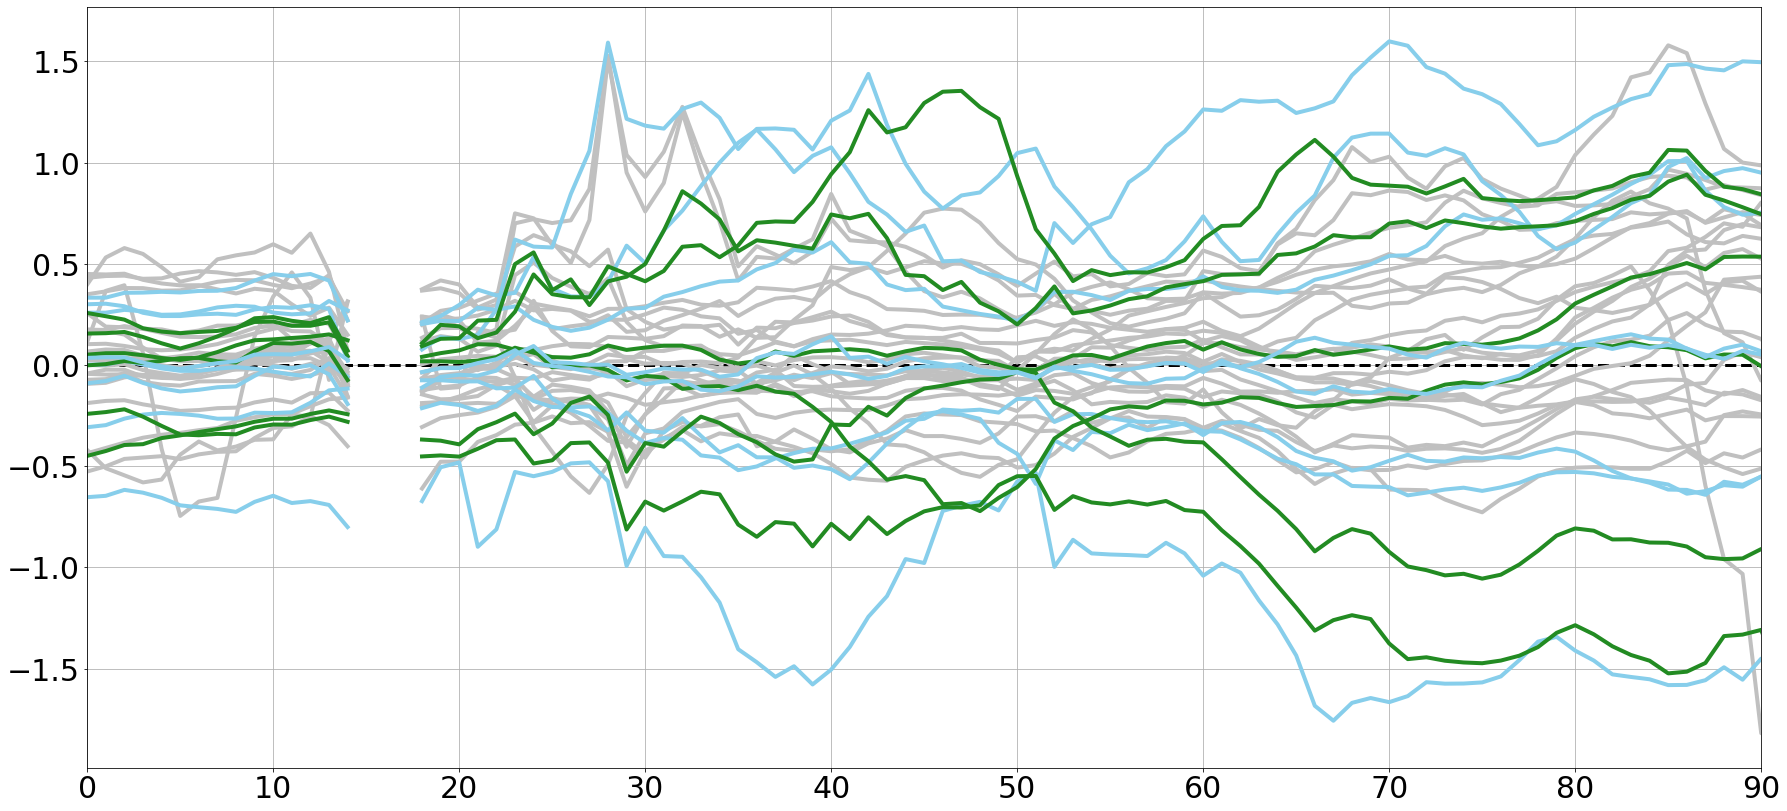

In [73]:
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(30,14))
plt.grid()
plt.axhline(y=0,linestyle='--',color='k', linewidth=3)

for i,ds in enumerate(ensemble_coupled):
    desc=descriptions[i]
    if desc not in descs_plantwater:
        if desc not in descs_hydro:
            color='silver'
            plt.plot((var_array[:,:,i]*landfracweights).mean(dim='lon'),color=color,linewidth=4)
        
for i,ds in enumerate(ensemble_coupled):
    desc=descriptions[i]
    if desc in descs_plantwater:
        color='forestgreen'
        plt.plot((var_array[:,:,i]*landfracweights).mean(dim='lon'),color=color,linewidth=4)
    elif desc in descs_hydro:
        color='skyblue'
        plt.plot((var_array[:,:,i]*landfracweights).mean(dim='lon'),color=color,linewidth=4)
plt.xlim([0,90])
plt.savefig('ZonalMean.png')    

In [72]:
var_array.to_netcdf('TSKIN_delta.nc')

In [35]:
var_array[:,:,i].mean(dim='lon')

<xarray.DataArray (lat: 96)>
array([-2.41823083e+00, -1.82586270e+00, -1.64760128e+00, -1.88632231e+00,
       -2.46526898e+00, -3.08276621e+00, -3.08666206e+00, -2.62494211e+00,
       -1.88907890e+00, -1.12148104e+00, -5.68754968e-01, -4.39284198e-01,
       -2.42750810e-01, -2.31399156e-01, -8.31411397e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.94725776e-03, -1.59162365e-02,
       -2.59290499e-02, -1.09120929e-02, -1.70612624e-02, -3.19824617e-02,
       -4.00856738e-02, -5.69931640e-02, -7.07653061e-02, -1.01144246e-01,
       -1.14845739e-01, -1.30693827e-01, -1.57460247e-01, -1.60579239e-01,
       -1.77274862e-01, -1.71555074e-01, -1.86673059e-01, -1.69087767e-01,
       -1.69682432e-01, -1.62939457e-01, -1.36129916e-01, -1.37009977e-01,
       -1.53969067e-01, -1.47385703e-01, -1.49269885e-01, -1.76725227e-01,
       -1.52016533e-01, -1.55830356e-01, -1.68397167e-01, -1.51200946e-01,
       -1.50152820e-01, -1.43699752e-01, -1.70155404e-01, -1.46186986e-01,
       -1.43433231e-01, -1.28451781e-01, -1.45011342e-01, -2.00727495e-01,
       -2.74470748e-01, -3.28964973e-01, -3.74947136e-01, -3.80452669e-01,
       -3.85748099e-01, -4.26362217e-01, -4.42651516e-01, -4.48839828e-01,
       -4.90112832e-01, -4.76800262e-01, -4.79661099e-01, -4.99769895e-01,
       -4.72864492e-01, -4.99819893e-01, -5.17015196e-01, -5.44913666e-01,
       -5.55932109e-01, -6.07870119e-01, -6.78004677e-01, -6.73402492e-01,
       -6.68298465e-01, -6.26342361e-01, -6.35111646e-01, -6.55597123e-01,
       -6.84353720e-01, -7.42419302e-01, -7.75294206e-01, -7.81323475e-01,
       -8.39587901e-01, -7.89393130e-01, -7.27365957e-01, -7.86246325e-01,
       -8.96523540e-01, -8.71655648e-01, -8.85045494e-01, -5.00904206e-01,
       -1.06426665e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
Coordinates:
  * lat           (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
    ensemble_key  <U4 '0012'

### Get area weights

#### Calculate area weights

In [21]:
import load_gridcell_areas

In [22]:
# area dataArray
ds_to_analyze=var_array[:,:,0]
da_area = area_grid(ds_to_analyze.lat, ds_to_analyze.lon)
# total area
total_area = da_area.sum(['lat','lon'])
#  weighted by grid-cell area
areaweights = (da_area) / total_area

In [23]:
if domain=='atm':
    landweights=landweights.reindex_like(areaweights, tolerance=0.05, method='nearest')

# Pattern of change in global mean warming

In [20]:
T_1xCO2=xr.open_dataset('/glade/work/czarakas/disentangling_lai_effects/postprocessed_model_output/coupled_DEFmedslope_1xCO2_all/'+
                        'coupled_DEFmedslope_1xCO2_all.cam.h0.timeseries.TS.nc')
T_2xCO2=xr.open_dataset('/glade/work/czarakas/disentangling_lai_effects/postprocessed_model_output/coupled_DEFmedslope_2xCO2_FULL_03/'+
                        'coupled_DEFmedslope_2xCO2_FULL_03.cam.h0.timeseries.TS.nc')

In [32]:
weight_factor = ds_h0.gw / ds_h0.gw.mean(dim='lat')

In [21]:
CO2_1x=T_1xCO2.TS[60*12:1440,:,:].mean(dim='time')
CO2_2x=T_2xCO2.TS[60*12:1440,:,:].mean(dim='time')

In [22]:
delta_T=CO2_2x-CO2_1x
delta_T=delta_T.reindex_like(landweights, method='nearest',tolerance=0.05)
CO2x2_warming_factor_1degreeglobal=1/(delta_T*landweights).mean(dim=['lat','lon'])

In [33]:
(delta_T*weight_factor).mean(dim=['lat','lon'])

<xarray.DataArray ()>
array(3.97905345)

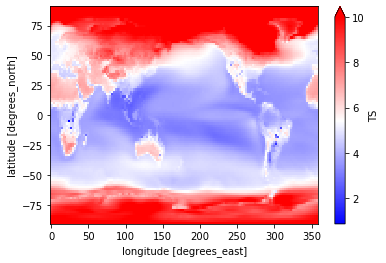

In [36]:
delta_T.plot(vmax=10, cmap=plt.cm.bwr)

In [24]:
(delta_T*landweights).mean(dim=['lat','lon'])

<xarray.DataArray ()>
array(6.511213, dtype=float32)

# EOF analysis of changes in mean temperature

### Set up data

In [24]:
var_array=var_array#[:,:,0:34]

In [ ]:
def quick_map_subplot_contour(mapdata_for_subplot, lat, lon, nrow=3, ncol=3, ind=1, title=None,
              cmap=None, clim=None, sigmask=None,plot_cbar=False):
    """ Creates map """
    ax = plt.subplot(nrow, ncol, ind+1, projection=ccrs.Robinson())
    ax.coastlines(resolution='110m') #learn how to add resolution here??
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata_for_subplot, coord=lon)

    cs = plt.contourf(cyclic_lons, lat, cyclic_data,
                            transform=ccrs.PlateCarree(), extend='both',levels=np.linspace(clim[0],clim[1],10),
                     add_colorbar=False)

    if sigmask is not None:
        cyclic_data_mask, cyclic_lons_mask = add_cyclic_point(sigmask, coord=lon)
        ax.contourf(
            cyclic_lons_mask, lat, cyclic_data_mask,
            transform=ccrs.PlateCarree(),
            colors='none',
            levels=[0.5, 1.5],
            hatches=['////'])
        
    # Choose your colormap
    if cmap:
        plt.set_cmap(cmap)
    else:
        plt.set_cmap(plt.cm.viridis)

    ax.patch.set_alpha(1.0)
    
    if title is not None: plt.title(title, fontsize=14)

    if clim:
        plt.clim(clim)
        cs.set_clim(clim[0], clim[1])
        cs.set_clim(clim)
    
    if plot_cbar:
        cbar = plt.colorbar(ax=ax, orientation='horizontal',
                                extend='both', pad=.02, shrink=0.9)
        cbar.ax.tick_params(labelsize=14)

        if clim:
            cbar.set_clim(clim)

In [ ]:
crosswalk_descriptions_short=['rhosnir, min', 'rhosnir, max', 'd_max, min', 'd_max, max',
       'frac_sat_soil_..., min', 'frac_sat_soil_..., max',
       'maximum_leaf_wet..., min',
       'maximum_leaf_wet..., max', 'fff, min', 'fff, max',
       'upplim_destruct_..., min', 'upplim_destruct_..., max',
       'medlynslope, max', 'medlynintercept, min', 'tpu25ratio, min',
       'tpu25ratio, max', 'jmaxb0, max', 'jmaxb1, min', 'jmaxb1, max',
       'kmax, min', 'kmax, max', 'nstem, min', 'nstem, max', 'lmrha, min',
       'lmrha, max', 'medlynslope, min', 'jmaxb0, min',
       'medlynintercept, max', 'sand_pf, min', 'sand_pf, max',
       'z0mr, min', 'z0mr, max', 'zsno, min', 'zsno, max',
       'zetamaxstable, min', 'zetamaxstable, max']

In [ ]:
# This is to reorder the ensemble members so parameters are next to each other
int_list=[0,1,2,3,4,5,
          8,9,28,29,6,7,
          25,12,13,27,19,20,
          14,15,26,16,17,18,
          23,24,21,22,10,11,
          32,33,30,31,34,35]

In [ ]:
var_change_weighted=var_array/(var_array*landweights).mean(dim=['lat','lon'])

In [ ]:
global_means=(var_array*landweights).mean(dim=['lat','lon'])

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(30,20))
for j,i in enumerate(int_list):
    plt.subplot(6,6,j+1)
    mapdata_for_subplot=var_array[:,:,i].where(landweights>0)
    sigmask=var_array_pval[:,:,i]>0.05

    title=crosswalk_descriptions_short[i]+' ('+str(np.round(fracs_changed[i]*100))+'% '+Walker_tests[i]+')'
    if i<40:
        quick_map_subplot_contour(mapdata_for_subplot, 
                                mapdata_for_subplot.lat, 
                                mapdata_for_subplot.lon, nrow=6, ncol=6, ind=j,
                               cmap=plt.cm.RdBu_r, clim=[-2,2],title=title,
                     sigmask=sigmask)
    else:
        quick_map_subplot_contour(mapdata_for_subplot, 
                                mapdata_for_subplot.lat, 
                                mapdata_for_subplot.lon, nrow=6, ncol=6, ind=j,
                               cmap=plt.cm.RdBu_r, clim=[-2,2],title=crosswalk.description.values[i],
                     sigmask=sigmask, plot_cbar=True)
    
plt.tight_layout()
plt.savefig('Global_'+var+'_maps_'+ensemble+'_'+season+'.png')

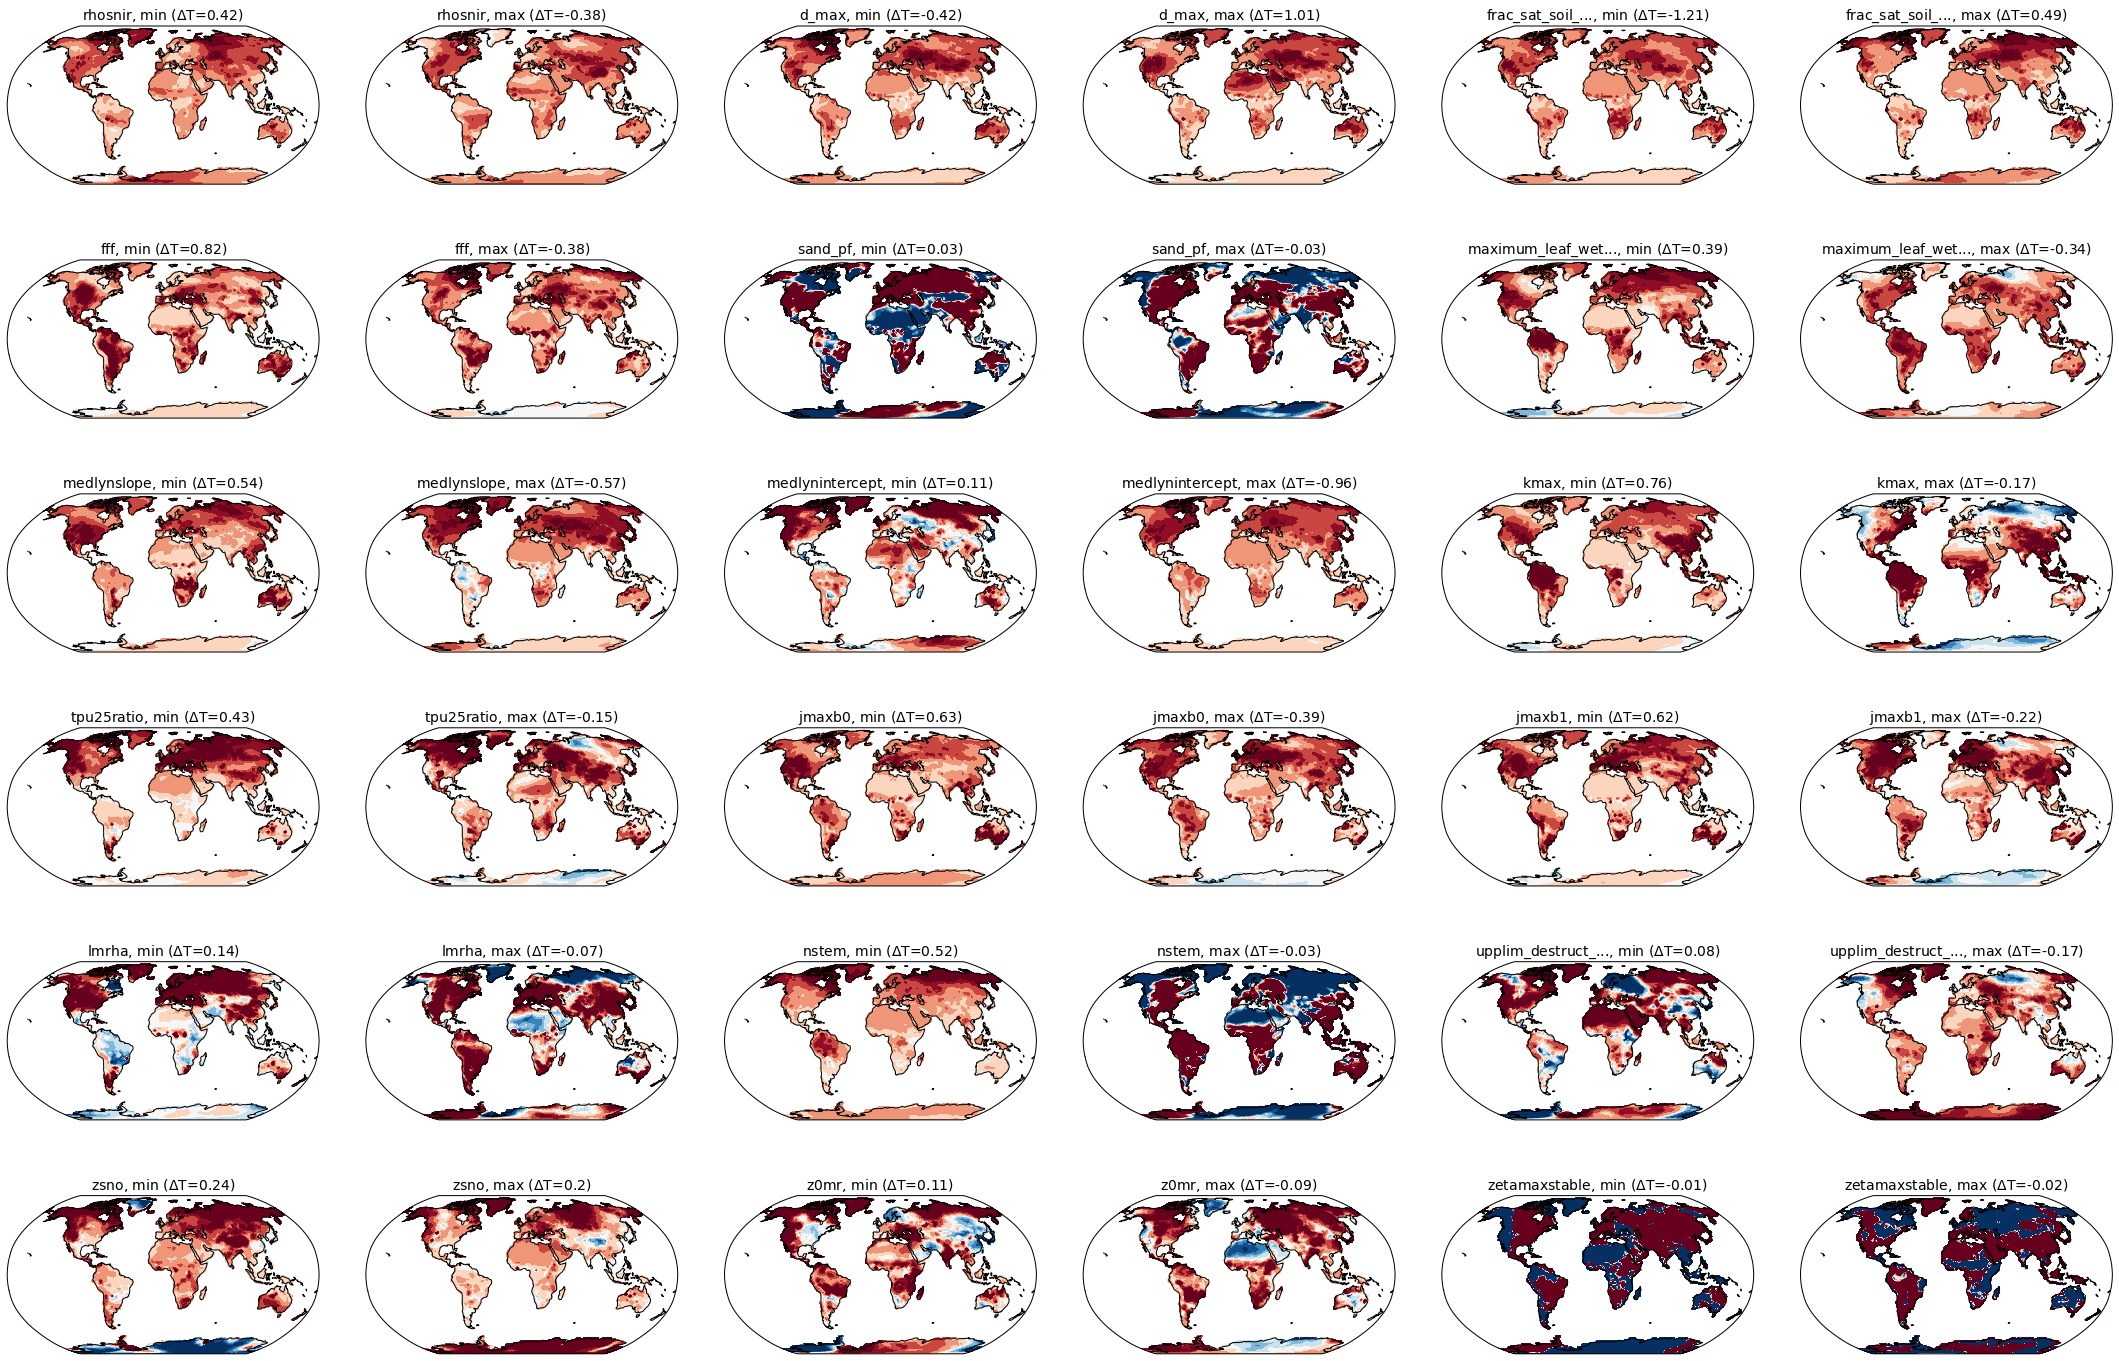

In [191]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(30,20))
for j,i in enumerate(int_list):
    plt.subplot(6,6,j+1)
    mapdata_for_subplot=var_change_weighted[:,:,i].where(landweights>0)
    sigmask=var_array_pval[:,:,i]>0.05
    

    if 
    title=crosswalk_descriptions_short[i]+' ($\Delta$T='+str(np.round(global_means.values[i],2))+')'
    if i<40:
        quick_map_subplot_contour(mapdata_for_subplot, 
                                mapdata_for_subplot.lat, 
                                mapdata_for_subplot.lon, nrow=6, ncol=6, ind=j,
                               cmap=plt.cm.RdBu_r, clim=[-2,2],title=title,
                     sigmask=None)
    else:
        quick_map_subplot_contour(mapdata_for_subplot, 
                                mapdata_for_subplot.lat, 
                                mapdata_for_subplot.lon, nrow=6, ncol=6, ind=j,
                               cmap=plt.cm.RdBu_r, clim=[-2,2],title=crosswalk.description.values[i],
                     sigmask=None, plot_cbar=True)
    
plt.tight_layout()
plt.savefig('Global_'+var+'_perGlobalT_maps_'+ensemble+'_'+season+'.png')

### Do EOF

In [9]:
path_in='/glade/work/czarakas/coupled_PPE/data/data_for_figures/'
var_array=xr.open_dataset(path_in+'delta_TSKIN_Annual_mean.nc')

In [13]:
var_array_temp=var_array.TSKIN[:,:,:]
deltaT=(var_array_temp-var_array_temp.mean(dim='ensemble_key'))

#var_array_temp=var_array
#deltaT=(var_array-var_array.mean(dim='ensemble_key'))

In [11]:
deltaT_global=(deltaT*landweights).mean(dim=['lat','lon'])
deltaT_normalized=deltaT#-deltaT_global

NameError: name 'deltaT' is not defined

In [14]:
ds_eofs = deltaT#[:,:,0:34]
ds_eofs=ds_eofs#*86400*365*1000

In [15]:
from datetime import datetime, timedelta
num_ensembles=np.shape(ds_eofs)[2]
print(num_ensembles)
date2=datetime(2000,1,1)+timedelta(days=num_ensembles, minutes=0)
date2_str=date2.isoformat()[0:10]

36


In [16]:
# Rearrange all-model dataset for EOF
ds_eofs=ds_eofs.transpose()
ds_eofs=ds_eofs.rename({"ensemble_key": "time"})
ds_eofs['time']=np.arange('2000-01-01', date2_str, dtype='datetime64') #11
ds_eofs=ds_eofs-ds_eofs.mean(dim='time')

In [18]:
from load_gridcell_areas import *

In [19]:
#solver = Eof(ds_eofs, weights=areaweights.transpose())
solver = Eof(ds_eofs, weights=landweights.transpose())
eofs = solver.eofs()
eofs = eofs.transpose()
pcs = solver.pcs()#pcscaling=2)

#### Check reconstruction

In [20]:
reconstructed=solver.reconstructedField(1)
reconstructed_mode0=eofs[:,:,0]*pcs[:,0]/landweights

In [21]:
diff=reconstructed_mode0[:,:,1]-reconstructed[1,:,:]

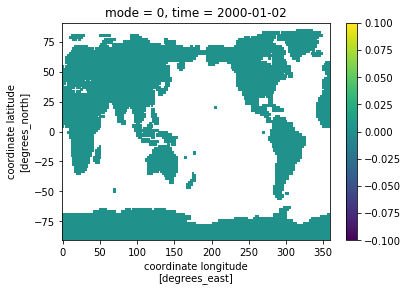

In [22]:
diff.plot()

## Make figures

##### Map of range

In [23]:
import matplotlib as mpl
# force the first color entry to be grey
cmaplist=['#4A50A4','#5B7DB7','#A9D9E4', '#7FC883','#57B041',
          '#AACF46','#EFE151','#F1CF45','#E6A53C','#D3582A',
          '#C83E2C','#A02C40','#591A8E']


# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, 14)

In [24]:
datarange=(var_array.quantile(0.95, dim='ensemble_key')-
           var_array.quantile(0.05, dim='ensemble_key'))

In [25]:
mapdata=datarange

AttributeError: 'Dataset' object has no attribute 'shape'

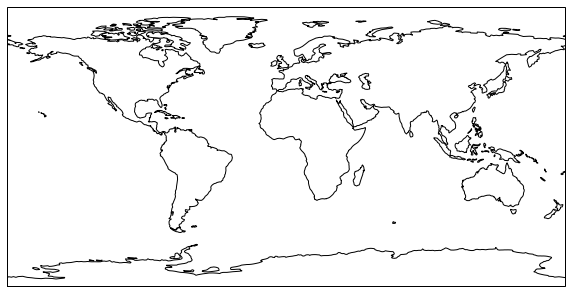

In [26]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.contourf(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=cmap, levels=np.arange(0, 3.25, 0.25), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree(), extend='both')
plt.colorbar(extend='both', orientation='horizontal', ticks=np.arange(0, 3.25, 0.25))
plt.tight_layout()
plt.savefig('EOF2_TSKIN_'+ensemble+'.png')

In [27]:
datarange.plot(cmap=cmap, vmin=0, vmax=3.25)

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

#### Fraction of variance explained

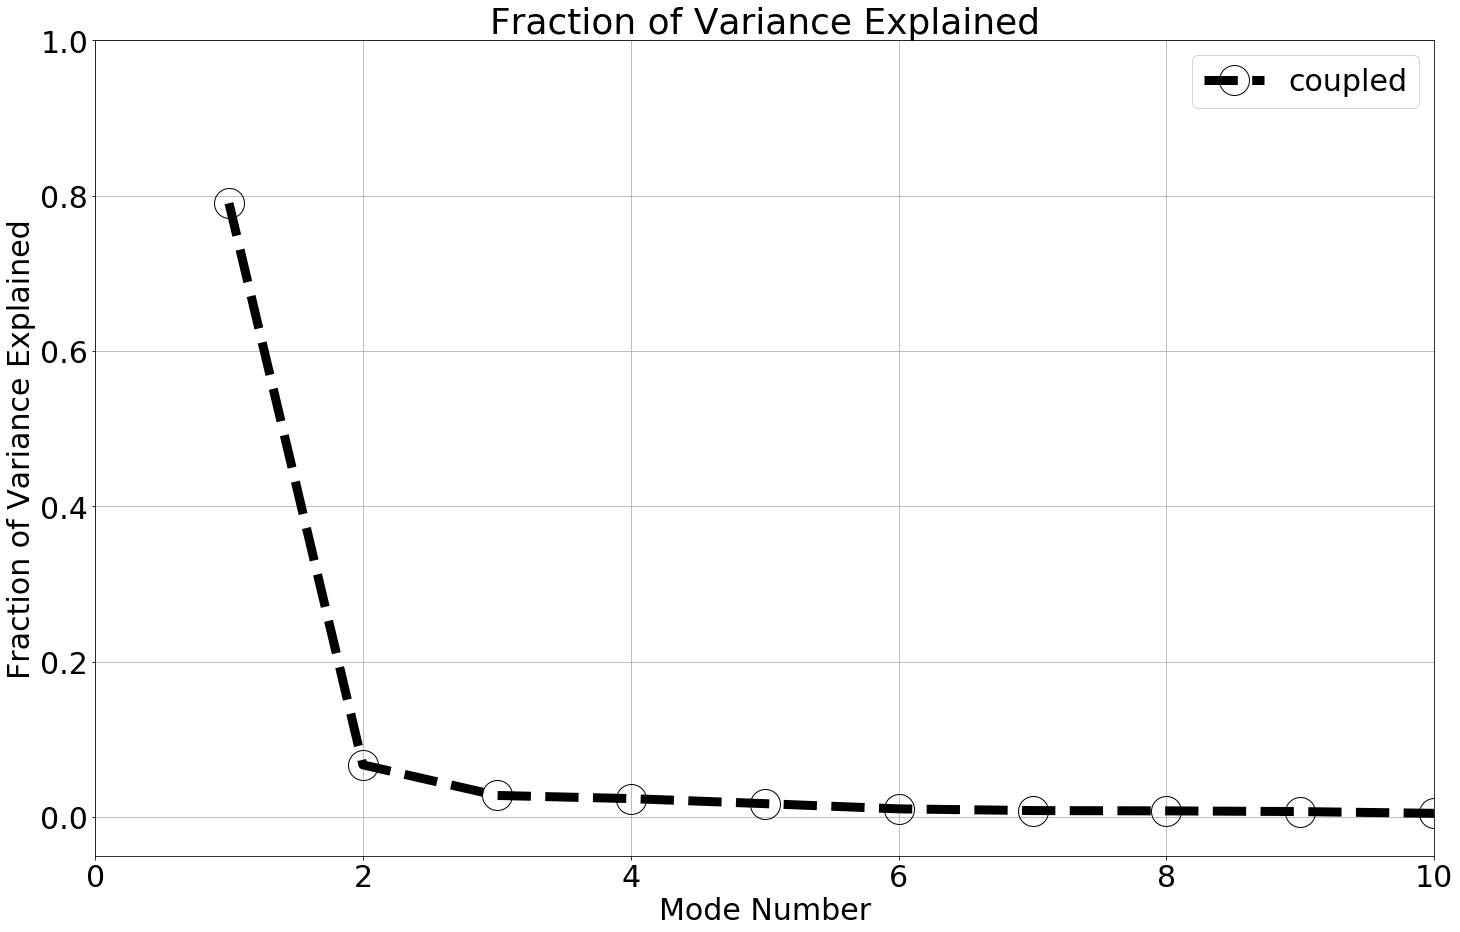

In [28]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(24,15))
plt.plot(np.arange(1,np.size(ds_eofs['time'])+1),solver.varianceFraction().values,
         'o--k', fillstyle='none',markersize=30,linewidth=9, label=ensemble)
solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([0,10])
plt.ylim([-0.05,1])
plt.title('Fraction of Variance Explained')
plt.xlabel('Mode Number')
plt.ylabel('Fraction of Variance Explained')
plt.grid()
plt.legend()
plt.savefig(var+'_frac_variance_explained.png')

In [29]:
for i in np.arange(0,4):
    print('EOF '+str(i+1))
    print(solver.varianceFraction().values[i])
#print(solver.varianceFraction().values[0:2])

EOF 1
0.7903187153242219
EOF 2
0.06709866622859308
EOF 3
0.0277204709529544
EOF 4
0.02364642327202232


In [30]:
warming_factorPC0_1degreeglobal=1/(eofs[:,:,0]).mean(dim=['lat','lon'])
warming_factorPC1_1degreeglobal=1/(eofs[:,:,1]).mean(dim=['lat','lon'])
warming_factorPC2_1degreeglobal=1/(eofs[:,:,2]).mean(dim=['lat','lon'])
warming_factorPC3_1degreeglobal=1/(eofs[:,:,3]).mean(dim=['lat','lon'])

/glade/u/home/czarakas/coupled_PPE/code/utils/quick_map.py:82: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(clim)


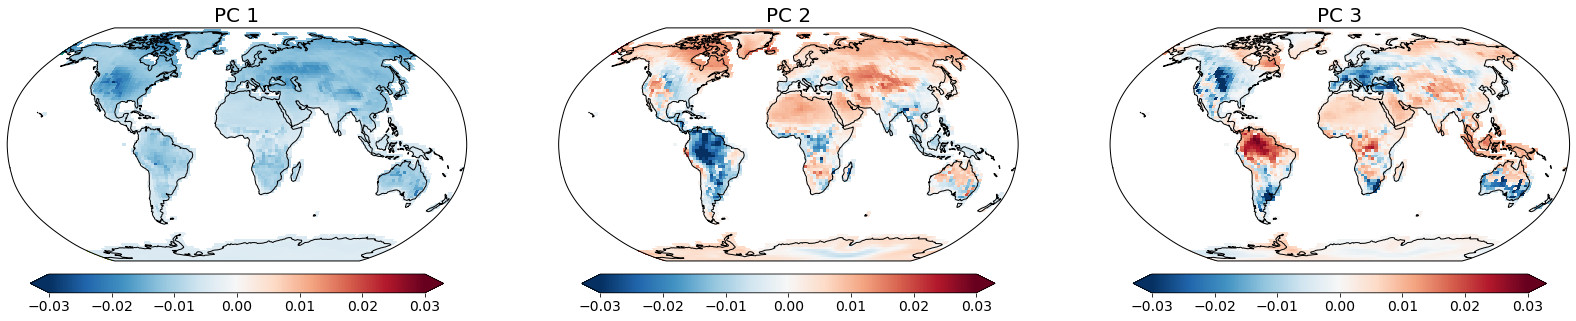

In [31]:
lats = eofs['lat'].values
lons = eofs['lon'].values
fig = plt.figure(figsize=(28, 12))
for i in range(0,3):
    quick_map.quick_map_subplot(((eofs[:,:,i])/landweights).values,lats,lons, nrow=1, ncol=3, ind=i,
                                clim=[-0.03,0.03], cmap=plt.cm.RdBu_r,
                                title='PC '+str(i+1))
plt.savefig(var+'_PCs.png')

In [32]:
mapdata=eofs[:,:,0]*warming_factorPC0_1degreeglobal/landweights
print((mapdata*landweights).mean(dim=['lat','lon']))

<xarray.DataArray ()>
array(1.)
Coordinates:
    mode     int64 0


In [33]:
mapdata2=delta_T.where(landweights>0)*CO2x2_warming_factor_1degreeglobal
print((delta_T.where(landweights>0)*CO2x2_warming_factor_1degreeglobal*landweights).mean(dim=['lat','lon']))
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata2.where(landfrac>0.3), coord=mapdata2.lon)

plt.pcolormesh(cyclic_lons, mapdata2.lat, #contourf
                   cyclic_data, 
                   cmap=plt.cm.get_cmap("RdBu_r",10), vmin=-2, vmax=2, #levels=np.arange(-2.0,2.1,0.4), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree())#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')#, ticks=np.arange(-2.0,2.1,0.4))
plt.tight_layout()
plt.savefig('EOF2_TSKIN_'+ensemble+'.png')

NameError: name 'delta_T' is not defined

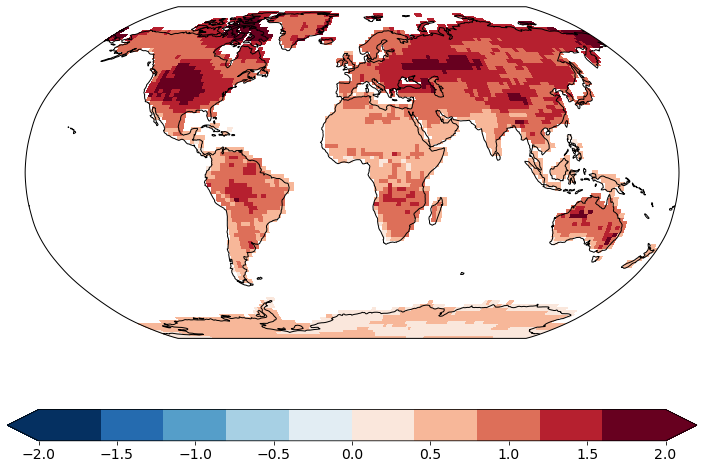

In [35]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata.where(landfrac>0.3), coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=plt.cm.get_cmap("RdBu_r",10), vmin=-2, vmax=2, #levels=np.arange(-2.0,2.1,0.4), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree())#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')#, ticks=np.arange(-2.0,2.1,0.4))
plt.tight_layout()
plt.savefig('EOF2_TSKIN_'+ensemble+'.png')

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


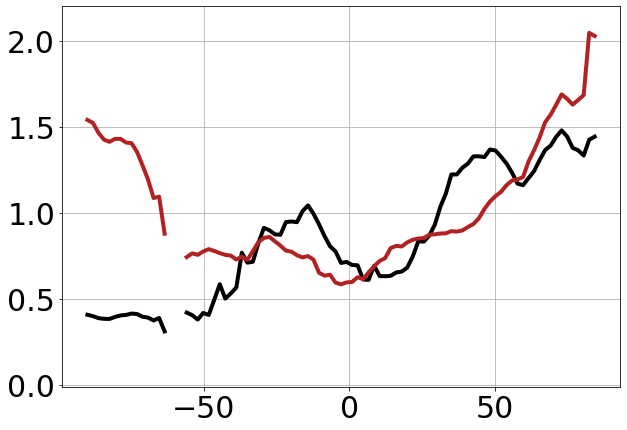

In [129]:
plt.figure(figsize=(10,7))
plt.plot(mapdata_coupled.lat, mapdata_coupled.mean(dim='lon'),color='black',linewidth=4)
#plt.plot(mapdata.lat, mapdata.mean(dim='lon'),color='black',linestyle='--',linewidth=2)
plt.plot(mapdata2.lat, mapdata2.mean(dim='lon'),color='firebrick',linewidth=4)
plt.ylim([-0.01, 2.2])
plt.savefig('ZonalMean_Comparison.png')
plt.grid()

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, clim=[-2, 2], vmin=-2, vmax=2,
                   cmap=plt.cm.get_cmap("RdBu_r"), #levels=np.arange(-2.6,2.7,0.4), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree(), )#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')
plt.tight_layout()
plt.savefig('EOF2_CLDTOT.png')

# In EOF space 

In [39]:
plt.rcParams.update({'font.size': 14})

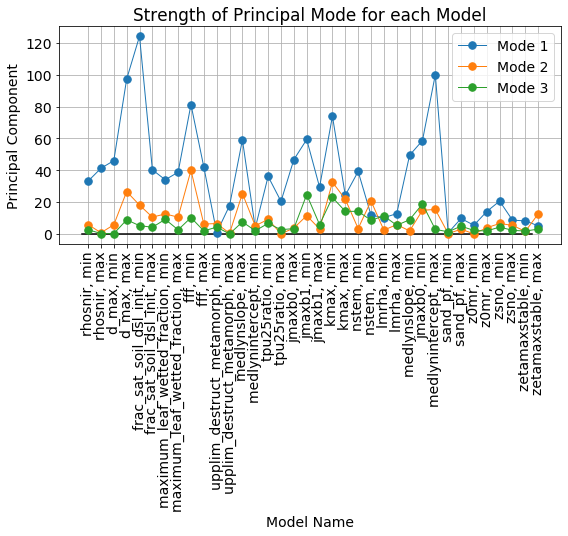

In [40]:
labels=descriptions#var_array.ensemble_key.values
fig = plt.figure(figsize=(9, 4))
plt.plot([0.5,np.size(labels)-0.5],[0,0],'-k')
for i in range(0,3):
    pcs_annual = np.abs(pcs[:,i])
    plt.plot(np.arange(1,np.size(pcs_annual['time'])+1),
             pcs_annual,label='Mode '+str(i+1),linewidth=1,marker='.',markersize=15)
    plt.xlabel('Model Name')
    plt.ylabel('Principal Component')
    plt.title('Strength of Principal Mode for each Model')
plt.legend()
#plt.xlim([0.5,np.size(labels)-0.5])
plt.xticks(np.arange(1,np.size(labels)+0.5,1),labels=labels, rotation=90)
plt.grid()
plt.savefig(var+'_strength_principal_mode_per_sim.png')

In [41]:
markerstyles=['o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'o',
             'o',
             'o',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v']

In [42]:
fillstyles=['none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'full',
             'none',
             'none',
             'full',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
            'none',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
           'none']

In [43]:
colors=['tab:blue',
             'tab:blue',
             'tab:orange',
             'tab:orange',
             'tab:green',
             'tab:green',
             'tab:red',
             'tab:red',
             'tab:purple',
             'tab:purple',
             'tab:brown',
             'tab:brown',
             'tab:pink', #WRONG
             'tab:olive', #WRONG
             'tab:cyan',
              'tab:cyan',
        'tab:gray',
            'tab:blue',
             'tab:blue',
             'tab:orange',
             'tab:orange',
             'tab:green',
             'tab:green',
             'tab:red',
             'tab:red',
             'tab:pink',
             'tab:gray',
             'tab:olive',
             'tab:pink',
             'tab:pink',
             'tab:cyan',
              'tab:cyan',
       'tab:gray',
       'tab:gray',
       'tab:olive',
        'tab:olive']

# Compare leading PC with global mean warming

In [44]:
global_mean_deltaT=[]
for m, modelname in enumerate(labels):
    deltaT_global=(deltaT_normalized[:,:,m]*landweights).mean(dim=['lat','lon']).values
    global_mean_deltaT.append(deltaT_global)

In [36]:
plt.plot(np.array(global_mean_deltaT),
         pcs[:,0].values/(warming_factorPC0_1degreeglobal.values),'o')
plt.grid()
plt.xlabel('Global Mean Change in Land Temperature')
plt.ylabel('PC1')
#plt.plot([-,1],[-2,1],'-k')

NameError: name 'global_mean_deltaT' is not defined

In [37]:
(pcs[:,0].values/(warming_factorPC0_1degreeglobal.values)

array([ 0.31918171, -0.40134902, -0.46095002,  0.97744731, -1.24609204,
        0.40214013,  0.34613575, -0.38629341,  0.81790044, -0.40474692,
        0.0078197 , -0.15199955, -0.57375008,  0.01138177,  0.32838282,
       -0.20377606, -0.47229971,  0.59280256, -0.30730377,  0.75023902,
       -0.23130313,  0.39438547, -0.12693885,  0.09259036, -0.13357447,
        0.50230721,  0.56127028, -0.98342154,  0.02112329, -0.1079188 ,
        0.0460776 , -0.14449237,  0.18623578,  0.06689998, -0.06206422,
       -0.0260472 ])

In [48]:
pcs[:,0].values/(warming_factorPC0_1degreeglobal.values)

array([ 0.33266225, -0.41396735, -0.46207212,  0.97655745, -1.24656937,
        0.40427629,  0.34139569, -0.3891468 ,  0.8155648 , -0.42196592,
        0.00852112, -0.17841616, -0.59322856,  0.03797196,  0.36263269,
       -0.20544083, -0.46845532,  0.5955424 , -0.29520126,  0.74249829,
       -0.24356289,  0.39368681, -0.11824164,  0.10243786, -0.12783824,
        0.49612752,  0.5887434 , -1.0040403 , -0.00691545, -0.09728173,
        0.05466454, -0.14120821,  0.206904  ,  0.08667939, -0.08222584,
       -0.05108848])

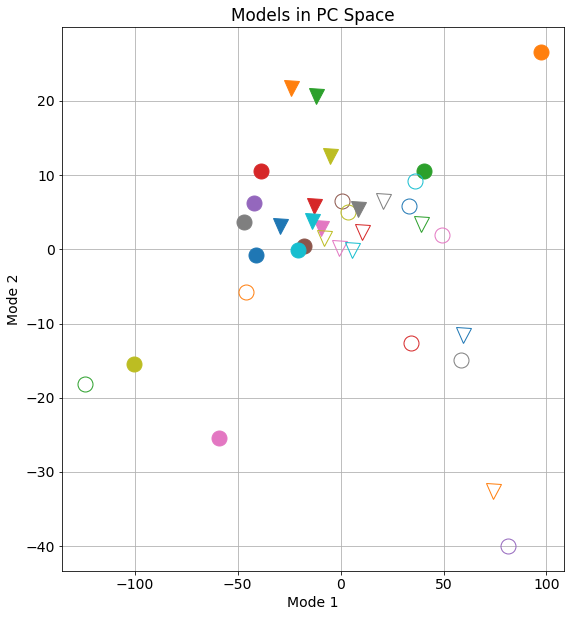

In [46]:
fig = plt.figure(figsize=(9, 10))
#plt.plot([-500,170],[0,0],'-k')
#plt.plot([0,0],[-175,150],'-k')
pc1 = (pcs[:,0].values)
pc2 = (pcs[:,1].values)
for m, modelname in enumerate(labels):
    if m%2==0:
        fillstyle='none'
    else:
        fillstyle='full'
    plt.plot(-pc1[m], pc2[m],markerstyles[m],color=colors[m],fillstyle=fillstyles[m],
             linewidth=0,markersize=15, label=modelname)
    #plt.plot(-pc1[m], pc2[m],markerstyles[m],'.,fillstyle=fillstyles[m],
    #         linewidth=0,markersize=15, label=modelname)
    #plt.annotate(modelname, [-pc1[m]+0.0002, pc2[m]-0.0001])
plt.xlabel('Mode 1')
plt.ylabel('Mode 2')
plt.title('Models in PC Space')
#plt.legend(fontsize=8, ncol=3)
#plt.xlim([-0.009,0.007])
#plt.ylim([-0.009,0.007])
#plt.ylim([-20,70])
plt.grid()
plt.savefig(var+'_PC1vsPC2_projection.png')

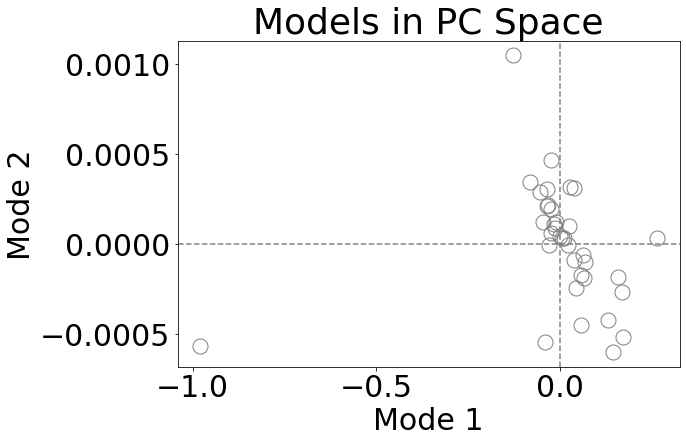

In [97]:
fig = plt.figure(figsize=(9, 6))
#plt.plot([-500,170],[0,0],'-k')
#plt.plot([0,0],[-175,150],'-k')
pc1 = pcs[:,0].values
pc2 = pcs[:,1].values
for m, modelname in enumerate(labels):
    if modelname=='CESM2':
        plt.plot(pc1[m], pc2[m],'.k',linewidth=0,markersize=15, label=modelname)
    else:
        plt.plot(pc1[m]/warming_factorPC0_1degreeglobal, 
                 pc2[m]/warming_factorPC1_1degreeglobal,
                 marker='o',fillstyle='none',color='gray',linewidth=0,markersize=15, label=modelname)

    if np.abs(pc1[m]/warming_factorPC0_1degreeglobal)>40:#0.75:
        plt.annotate(modelname, [pc1[m]/warming_factorPC0_1degreeglobal, 
                 pc2[m]/warming_factorPC1_1degreeglobal,])
    if np.abs(pc2[m]/warming_factorPC1_1degreeglobal)>0.1:#0.005:
        plt.annotate(modelname, [pc1[m]/warming_factorPC0_1degreeglobal, 
                pc2[m]/warming_factorPC1_1degreeglobal,])

plt.xlabel('Mode 1')
plt.ylabel('Mode 2')
plt.title('Models in PC Space')
#plt.legend(fontsize=12)
#plt.xlim([-110,150])
plt.axhline(y=0,linestyle='--',color='gray')
plt.axvline(x=0,linestyle='--',color='gray')
#plt.ylim([-0.1,0.1])
plt.savefig(var+'_PC1vsPC2_projection.png')

# Bar chart

In [101]:
crosswalk['PCmode1']=np.nan
pc0=pcs[:,0]/(warming_factorPC0_1degreeglobal)

for i, desc in enumerate(var_array.ensemble_key.values):
    crosswalk['PCmode1'][i+1]=pc1[i]

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [105]:
params=['frac_sat_soil_dsl_init','d_max', 'fff','sand_pf',
        'upplim_destruct_metamorph', 'z0mr', 'zetamaxstable', 'zsno',
        'medlynintercept','kmax','medlynslope',
        'jmaxb0', 'jmaxb1', 'tpu25ratio',
        'rhosnir',
        'lmrha',
        'nstem','maximum_leaf_wetted_fraction']
param_colors=['blue','blue', 'blue','blue',
        'purple', 'purple', 'purple', 'purple',
        'forestgreen', 'forestgreen', 'forestgreen',
        'lightseagreen', 'lightseagreen','lightseagreen',
              'goldenrod',
              'lightgreen',
        'orange','orange']

(-1, 18)

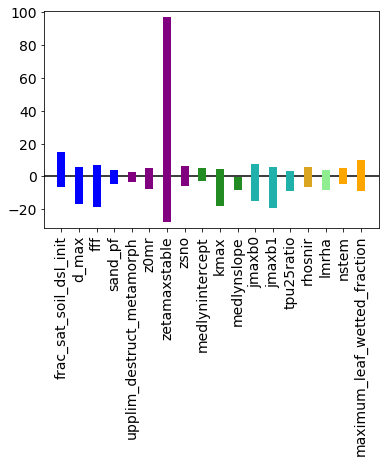

In [107]:
plt.rcParams.update({'font.size': 14})
plt.plot([-1,np.size(params)],[0,0],'-k')
for i, param in enumerate(params):
    minval=crosswalk['PCmode1'].values[crosswalk.description==param+', min']
    maxval=crosswalk['PCmode1'].values[crosswalk.description==param+', max']
    plt.plot([i,i], [minval,maxval],'.-', linewidth=8, color=param_colors[i])

plt.xticks(np.arange(0, i+1), params, rotation='vertical')
plt.xlim([-1,np.size(params)])